### tensorflow and numpy

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
a = np.zeros((2,2)); b = np.ones((2,2))
np.sum(b, axis=1)

array([ 2.,  2.])

In [3]:
a.shape

(2, 2)

In [4]:
np.reshape(a, (1,4))

array([[ 0.,  0.,  0.,  0.]])

In [5]:
tf.InteractiveSession()
a = tf.zeros((2,2)); b = tf.ones((2,2))
tf.reduce_sum(b, reduction_indices=1).eval()

array([ 2.,  2.], dtype=float32)

In [6]:
a.get_shape()

TensorShape([Dimension(2), Dimension(2)])

In [7]:
a.shape

TensorShape([Dimension(2), Dimension(2)])

In [8]:
tf.reshape(a,(1,4)).eval()

array([[ 0.,  0.,  0.,  0.]], dtype=float32)

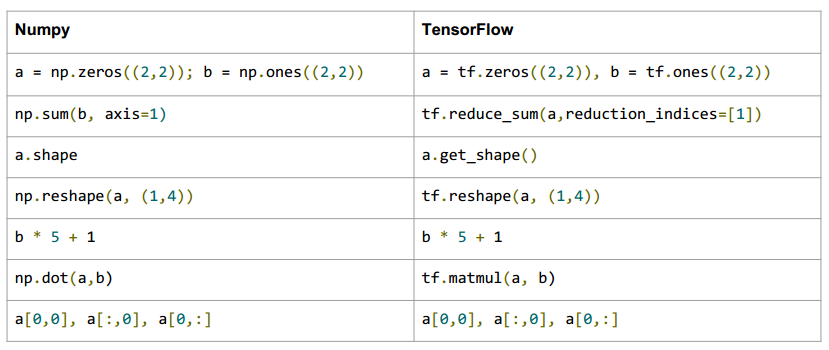

In [9]:
a = tf.constant(5.0)
b = tf.constant(6.0)
c = a * b
with tf.Session() as sess:
    print(sess.run(c))
print(c.eval())

30.0
30.0


- ```c.eval()``` is just syntactic sugar for sess.run(c) in the currently active session!
- ```tf.InteractiveSession()``` is just convenient syntactic sugar for keeping a default session open in ipython.
- ```sess.run(c)``` is an example of a TensorFlow Fetch. Will say more on this soon

### tensorflow computation graph

- “TensorFlow programs are usually structured into a construction phase, that assembles a graph, and an execution phase that uses a session to execute ops in the graph.” 
- All computations add nodes to global default graph

### TensorFlow Variables 

- “When you train a model you use variables to hold and update parameters. Variables are in-memory buffers containing tensors” 
- All tensors we’ve used previously have been constant tensors, not variables.

In [10]:
W1 = tf.ones((2,2))
W2 = tf.Variable(tf.zeros((2,2)), name='weight')
with tf.Session() as sess:
    print(sess.run(W1))
    sess.run(tf.initialize_all_variables())  # Note the initialization step 
    print(sess.run(W2))

[[ 1.  1.]
 [ 1.  1.]]
Instructions for updating:
Use `tf.global_variables_initializer` instead.
[[ 0.  0.]
 [ 0.  0.]]


-  TensorFlow variables must be initialized before they have values! Contrast with constant tensors

#### Updating Variable State

In [11]:
state = tf.Variable(0, name="counter")
new_value = tf.add(state, tf.constant(1))
update = tf.assign(state, new_value)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print(sess.run(state))
    for _ in range(3):
        print(sess.run([update,state]))

0
[1, 1]
[2, 2]
[3, 3]


- Calling sess.run(var) on a tf.Session() object retrieves its value. Can retrieve multiple variables simultaneously with sess.run([var1, var2])

### inputting data

- All previous examples have manually defined tensors. How can we input external data into TensorFlow?
-  Simple solution: Import from Numpy:

In [12]:
a = np.zeros((3,3))
ta = tf.convert_to_tensor(a)
with tf.Session() as sess:
    print(sess.run(ta))
print(ta.eval())

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


### Placeholders and Feed Dictionaries
- Inputting data with tf.convert_to_tensor() is convenient, but doesn’t scale.
- Use tf.placeholder variables (dummy nodes that provide entry points for data to computational graph).
- A feed_dict is a python dictionary mapping from tf.placeholder vars (or their names) to data (numpy arrays, lists, etc.).

In [13]:
input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)
output = tf.multiply(input1, input2) # element-wise. 注意和tf.matmul的区别
with tf.Session() as sess:
    print(sess.run([output], feed_dict={input1:[7.], input2:[2.]}))

[array([ 14.], dtype=float32)]


### Variable Scope
- Complicated TensorFlow models can have hundreds of variables.
    - ```tf.variable_scope()``` provides simple name-spacing to avoid clashes.
    - ```tf.get_variable()``` creates/accesses variables from within a variable scope.
    
- Variable scope is a simple type of namespacing that adds prefixes to variable names within scope

- Variable scopes control variable (re)use

In [14]:
with tf.variable_scope("foo"):
    with tf.variable_scope("bar"):
        v = tf.get_variable("v", [1], use_resource=True)
assert v.name == "foo/bar/v:0"


In [15]:
print(v.name)

foo/bar/v:0


In [16]:
with tf.variable_scope("foo"):
    v = tf.get_variable("v", [1])
    tf.get_variable_scope().reuse_variables()
    v1 = tf.get_variable("v", [1])
assert v1 == v

In [18]:
print(v1.name);print(v.name)

foo/v:0
foo/v:0


#### understanding get_variable

- Behavior depends on whether variable reuse enabled
- Case 1: reuse set to false
    - Create and return new variable

In [20]:
with tf.variable_scope("foo1"):
    v = tf.get_variable("v", [1])
assert v.name == "foo1/v:0"

- Case 2: Variable reuse set to true
    - Search for existing variable with given name. Raise ValueError if none found.

In [22]:
with tf.variable_scope("foo1", reuse=True):
    v1 = tf.get_variable("v", [1])
assert v1 == v

In [23]:
print(v1.name)

foo1/v:0
